# EECS 498 - Assignment 2 - languageIdentification.py
### By: Alexander "AJ" Goldstein - uniquename: ajva

In [1]:
import csv
import sys
import pandas as pd
import scipy
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from __future__ import division
from operator import add, sub
from random import shuffle
import matplotlib.pyplot as plt

## Pre-processing Functions:

### 1) read in and process data

In [2]:
# input 1: dataFile (string) - name of data file
# output 1: alphabet (dict) - unique dataFile characters (as keys) and their assigned alphaKey (as values)
# output 2: fiveCharAlphas (dict) - five character sequences (as keys) and their alphaKeys (as values)
# output 3: fiveCharLabels (dict) - five character sequences (as keys) and their languageCode (as values)

def read_in_and_process_data(dataFile, alphabet, fiveCharAlphas):
    
    # create dictionaries and variables for tracking pre-processing
    sentenceSeqs = {}
    sentenceLabels = {}
    fiveCharLabels = {}
    alphaCount = len(alphabet.keys())
    
    with open(dataFile) as data:
        for line in data:
            fiveCharSeqs = []
            language, space, sentence = line.partition(' ')
            
            # generate language encoding
            languageCode = []
            if language == 'ENGLISH':
                languageCode = [1,0,0]
            elif language == 'ITALIAN':
                languageCode = [0,1,0]
            elif language == 'FRENCH':
                languageCode = [0,0,1]
                
            # store new characters in alphabet dictionary
            for char in sentence:
                if (char not in alphabet):
                    alphabet[char] = alphaCount
                    alphaCount += 1
            
            # create & store five character sequences (w/ languageKeys & alphaKeys)
            for idx, char in enumerate(sentence):

                # create five char sequence
                if (idx + 5 <= len(sentence)):
                    fiveChars = sentence[idx:idx+5]
                    fiveCharSeqs.append(fiveChars)

                    # generate sequence alphaKeys
                    alphaKeys = []
                    for singleChar in fiveChars:
                        alphaKeys.append(alphabet[singleChar])

                    # store alphaKeys and language
                    fiveCharAlphas[fiveChars] = alphaKeys
                    fiveCharLabels[fiveChars] = languageCode
                    
            # store fiveCharSeqs into sentenceSeqs before selecting new sentence
            sentenceSeqs[sentence] = fiveCharSeqs
            sentenceLabels[sentence] = languageCode
                
    return alphabet, sentenceSeqs, sentenceLabels, fiveCharAlphas, fiveCharLabels

### 2) process TEST data (slightly different)

In [3]:
# input 1: dataFile (string) - name of data file
# output 1: alphabet (dict) - unique dataFile characters (as keys) and their assigned alphaKey (as values)
# output 2: fiveCharAlphas (dict) - five character sequences (as keys) and their alphaKeys (as values)
# output 3: fiveCharLabels (dict) - five character sequences (as keys) and their languageCode (as values)

def process_test_data(dataFile, solutionsFile, alphabet, fiveCharAlphas):
    
    # create dictionaries and variables for tracking pre-processing
    sentenceSeqs = {}
    sentenceLabels = {}
    fiveCharLabels = {}
    alphaCount = len(alphabet.keys())
    
    with open(dataFile) as data:
        with open(solutionsFile) as sol:
            for sentence, solLine in zip(data, sol):
                
                # set new storage
                fiveCharSeqs = []
                languageCode = []
                
                # get language from solutions
                lineNum, space, language = solLine.partition(' ')
                if language == 'English\n':
                    languageCode = [1,0,0]
                elif language == 'Italian\n':
                    languageCode = [0,1,0]
                elif language == 'French\n':
                    languageCode = [0,0,1]  
                
                # store new characters in alphabet dictionary
                for char in sentence:
                    if (char not in alphabet):
                        alphabet[char] = alphaCount
                        alphaCount += 1

                # create & store five character sequences (w/ languageKeys & alphaKeys)
                for idx, char in enumerate(sentence):

                    # create five char sequence
                    if (idx + 5 <= len(sentence)):
                        fiveChars = sentence[idx:idx+5]
                        fiveCharSeqs.append(fiveChars)

                        # generate sequence alphaKeys
                        alphaKeys = []
                        for singleChar in fiveChars:
                            alphaKeys.append(alphabet[singleChar])

                        # store alphaKeys and language
                        fiveCharAlphas[fiveChars] = alphaKeys
                        fiveCharLabels[fiveChars] = languageCode

                # store fiveCharSeqs into sentenceSeqs before selecting new sentence
                sentenceSeqs[sentence] = fiveCharSeqs
                sentenceLabels[sentence] = languageCode
                
    return alphabet, sentenceSeqs, sentenceLabels, fiveCharAlphas, fiveCharLabels

### 3) one-hot-encode five character sequences

In [4]:
# input 1: fiveCharAlphas (dict) - five character sequences (as keys) and their alphaKeys (as values)
# output 1: fiveCharEncodings (dict) - five character sequences (as keys) and their ONE-HOT ENCODINGS (as values)

def one_hot_encode_sequences(fiveCharAlphas):
    
    # create dictionary for encoding storage
    fiveCharEncodings = {}
    
    # fit encoder to given five character sequences
    enc = OneHotEncoder()
    enc.fit(fiveCharAlphas.values())
    
    # generate one-hot-encodings for every five character sequence
    for sequence, alphaKeys in fiveCharAlphas.items():
        encoding = enc.transform([alphaKeys]).todense()
        fiveCharEncodings[sequence] = encoding
    
    return fiveCharEncodings

## Neural Network Functions: Calculations

### 1) initialize weights

In [5]:
# initialize weight & bias matrices
def initialize_weights_and_biases(inputSize, hiddenSize, outputSize):
    weights1 = np.array([[np.random.uniform(low=(-1.0), high=(1.0)) for y in range(inputSize)] for x in range(hiddenSize)])
    weights2 = np.array([[np.random.uniform(low=(-1.0), high=(1.0)) for y in range(hiddenSize)] for x in range(outputSize)])
    biases1 = np.array([np.random.uniform(low=(-1.0), high=(1.0)) for y in range(hiddenSize)])
    biases2 = np.array([np.random.uniform(low=(-1.0), high=(1.0)) for y in range(outputSize)])
    
    return weights1, weights2, biases1, biases2

### 2) forward propogation

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-1*z))

In [7]:
# calculate hidden layer from input layer using sigmoid function
def calculate_hidden_layer(x, W1, b1):
    h_prime = np.array(map(add, np.dot(W1,x.T), b1))
    h = np.array(map(sigmoid, h_prime))
    h = h.reshape(h.shape[0], 1)
    return h, h_prime

In [8]:
def softmax(y):
    return np.exp(y)/(np.exp(y).sum())

In [9]:
def calculate_output_layer(h, W2, b2):
    y_prime = map(add, np.dot(W2,h), b2)
    y_pred = np.array(softmax(y_prime))
    y_pred = y_pred.reshape(y_pred.shape[0])
    return y_pred, y_prime

### 2) backpropogation

In [10]:
def calculate_squared_loss(y_pred, y_true):
    return 0.5*(pow(y_pred - y_true,2))

In [11]:
def softmax_grad(s):
    s = s.reshape(-1,1)
    s_ = s.reshape(1,-1)
    return np.diagflat(s_) - np.dot(s, s.T)

def loss_sqr_grad(y_pred, y_true):
    return y_pred - y_true

def loss_sqr_softmax_grad(y_pred, y_true):
    return np.dot(loss_sqr_grad(y_pred, y_true).T, softmax_grad(y_pred)).reshape(-1,1)

In [12]:
def backpropogation(x, h_prime, h, y_prime, y_pred, y_true, W1, W2):
    
    # output to hidden layer
    y_prime_loss = loss_sqr_softmax_grad(y_pred, y_true)
    
    # hidden layer
    W2_loss = np.dot(y_prime_loss,h.T)
    b2_loss = y_prime_loss
    h_loss = np.dot(W2.T,y_prime_loss)
    
    h_prime_loss = np.multiply(h_loss, np.multiply(h, (1.0-h)))
    
    # hidden layer to input layer
    W1_loss = np.dot(h_prime_loss,x)
    b1_loss = h_prime_loss
    x_loss = np.dot(W1.T,h_prime_loss)
    
    # make small reshapes
    b2_loss = np.array(b2_loss)
    b2_loss = b2_loss.reshape(b2_loss.shape[0])
    b1_loss = b1_loss.reshape(b1_loss.shape[0])
    
    return W1_loss, W2_loss, b1_loss, b2_loss

### 4) gradient descent

In [13]:
def gradient_descent(learningRate, W1, W2, b1, b2, W1_loss, W2_loss, b1_loss, b2_loss):
    
    # theta_new = theta_old - rate*loss
    W1_new = W1 - learningRate*W1_loss
    W2_new = W2 - learningRate*W2_loss
    b1_new = b1 - learningRate*b1_loss
    b2_new = b2 - learningRate*b2_loss
    
    return W1_new, W2_new, b1_new, b2_new

## Neural Network Functions: Implementation

### 1) calculate NN accuracy

In [14]:
# NOTE: replace sentenceSeqs with sentenceSeqs before official running!!

def calculate_NN_accuracy(sentenceSeqs, sentenceLabels, fiveCharEncodings, fiveCharLabels, W1, W2, b1, b2):
    
    # storage for each prediction
    predictions = {} # {sentence:languagePredict}
    predictOutcomes = [] #True/False for each prediction
    
    # loop through all the sentences
    for sentence, fiveCharSeqs in sentenceSeqs.items():
        sentencePredTotals = [0,0,0]
        
        # run the neural network on one five character sequence at a time
        for fiveChars in fiveCharSeqs:
    
            # generate input, hidden, and output layers
            x = np.array(fiveCharEncodings[fiveChars])
            h, h_prime = calculate_hidden_layer(x, W1, b1)
            y_pred, y_prime = calculate_output_layer(h, W2, b2)

            # add on current sequence prediction
            sentencePredTotals += y_pred
    
        # get true language for current sentence
        y_true = sentenceLabels[sentence]
        
        # check sentence prediction accuracy via majority vote of five character sequences
        # check for True or False prediction outcome
        predLang = np.argmax(sentencePredTotals)
        trueLang = y_true.index(max(y_true))
        predictOutcomes.append(True) if predLang == trueLang else predictOutcomes.append(False)
        
        # store language prediction
        langPredicted = ''
        if predLang == 0:
            langPredicted = 'English'
        elif predLang == 1:
            langPredicted = 'Italian'
        elif predLang == 2:
            langPredicted = 'French'
        predictions[sentence] = langPredicted
        
    # calculate overall accuracy of this run through
    accuracy = sum(predictOutcomes)/len(predictOutcomes)
    print("accuracy:",accuracy)
    
    return accuracy, predictions

### 2) train NN weights

In [15]:
# NOTE: replace sentenceSeqs with sentenceSeqs before official running!!

def train_neural_net(sentenceSeqs, fiveCharEncodings, fiveCharLabels, learningRate, W1, W2, b1, b2):
    
    fiveCharSeqs = list(fiveCharLabels.keys())
    shuffle(fiveCharSeqs)

    # run the neural network on one RANDOM five character sequence at a time
    for fiveChars in fiveCharSeqs:

        # generate input, hidden, and output layers
        x = np.array(fiveCharEncodings[fiveChars])
        h, h_prime = calculate_hidden_layer(x, W1, b1)
        y_pred, y_prime = calculate_output_layer(h, W2, b2)

        # get true language for current sentence
        y_true = fiveCharLabels[fiveChars]
        loss = calculate_squared_loss(y_pred, y_true)

        # conduct backpropogation
        W1_loss, W2_loss, b1_loss, b2_loss = backpropogation(x, h_prime, h, y_prime, y_pred, y_true, W1, W2)

        # use gradient descent to update weights with backpropogation gradients
        W1, W2, b1, b2 = gradient_descent(learningRate, W1, W2, b1, b2, W1_loss, W2_loss, b1_loss, b2_loss)
    
    # return new weights
    return W1, W2, b1, b2

### 3) run the neural network

In [16]:
# NOTE: replace sentenceSeqs with sentenceSeqs before official running!!

def run_neural_net(sentenceSeqs_t, sentenceLabels_t, fiveCharLabels_t, 
                   sentenceSeqs_d, sentenceLabels_d, fiveCharLabels_d, 
                   fiveCharEncodings, learningRate, hiddenSize, outputSize = 3):
    
    # set runCount and create accuracy storage
    runCount = 1
    NN_Accuracies = []
    
    # set inputSize, randomly initialize weights
    inputSize = fiveCharEncodings.values()[0].shape[1]
    W1, W2, b1, b2 = initialize_weights_and_biases(inputSize, hiddenSize, outputSize)
    
    # calculate & store starting accuracy on the train & dev data
    startTrainAcc, predictions = calculate_NN_accuracy(sentenceSeqs_t, sentenceLabels_t, fiveCharEncodings, fiveCharLabels_t, W1, W2, b1, b2)
    startDevAcc, predictions = calculate_NN_accuracy(sentenceSeqs_d, sentenceLabels_d, fiveCharEncodings, fiveCharLabels_d, W1, W2, b1, b2)
    NN_Accuracies.append([startTrainAcc, startDevAcc])
    
    while runCount <= 3:
        print("runCount =",runCount)
        
        # train neural net weights
        W1, W2, b1, b2 = train_neural_net(sentenceSeqs_t, fiveCharEncodings, fiveCharLabels_t, learningRate, W1, W2, b1, b2)
        
        # calculate & store accuracy with updated weights
        trainAccuracy, predictions = calculate_NN_accuracy(sentenceSeqs_t, sentenceLabels_t, fiveCharEncodings, fiveCharLabels_t, W1, W2, b1, b2)
        devAccuracy, predictions = calculate_NN_accuracy(sentenceSeqs_d, sentenceLabels_d, fiveCharEncodings, fiveCharLabels_d, W1, W2, b1, b2)
        NN_Accuracies.append([trainAccuracy, devAccuracy])
        
        # index runCount
        runCount += 1
    
    # return all accuracies & final NN weights
    return NN_Accuracies, W1, W2, b1, b2

## Optimize Hyperparameters Function:

In [17]:
def optimize_hyperparameters(sentenceSeqs_t, sentenceLabels_t, fiveCharLabels_t, 
                                 sentenceSeqs_d, sentenceLabels_d, fiveCharLabels_d,
                                     sentenceSeqs_TEST, sentenceLabels_TEST, fiveCharLabels_TEST, 
                                         fiveCharEncodings,  outputSize = 3):
    
    # 0) select at least 5 different sets of hyperparameter values
    hyperparams = []
    hyperparams.append([50,1.0])
    hyperparams.append([50,10.0])
    hyperparams.append([200,1.0])
    hyperparams.append([200,10.0])
    hyperparams.append([100,1.0])

    # 2) see which performs best on the dev data
    bestAccuracy = 0
    bestParams = []
    bestWeights = []

    for param in hyperparams:
        hiddenSize = param[0]
        learningRate = param[1]

        # set inputSize, randomly initialize weights
        inputSize = fiveCharEncodings.values()[0].shape[1]
        W1, W2, b1, b2 = initialize_weights_and_biases(inputSize, hiddenSize, outputSize = 3)

        # train network on the training data
        W1, W2, b1, b2 = train_neural_net(sentenceSeqs_t, fiveCharEncodings, fiveCharLabels_t, learningRate, W1, W2, b1, b2)

        # test on the dev data
        devAccuracy, predictions = calculate_NN_accuracy(sentenceSeqs_d, sentenceLabels_d, fiveCharEncodings, fiveCharLabels_d, W1, W2, b1, b2)

        # update best accuracy and parameters
        if devAccuracy > bestAccuracy:
            bestAccuracy = devAccuracy
            bestParams = [hiddenSize, learningRate]
            bestWeights = [W1, W2, b1, b2]

    # 3) use best hyperparameters to calculate accuracy on test data
    W1_best = bestWeights[0]
    W2_best = bestWeights[1]
    b1_best = bestWeights[2]
    b2_best = bestWeights[3]

    testAccuracy, predictions = calculate_NN_accuracy(sentenceSeqs_TEST, sentenceLabels_TEST,
                                                      fiveCharEncodings, fiveCharLabels_TEST,
                                                      W1_best, W2_best, b1_best, b2_best)

    return testAccuracy, bestParams

In [18]:
# SCRIPT NOTE: switch out arguments
# read in file names
trainFile = "languageIdentification.data/train"
devFile = "languageIdentification.data/dev"
testFile = "languageIdentification.data/test"

#trainFile = sys.argv[1]
#devFile = sys.argv[2]
#testFile = sys.argv[3]

testSolFile = "languageIdentification.data/test_solutions"

In [19]:
# read in and process trainFile, devFile, testFile
alphabet = {}
fiveCharAlphas = {}
alphabet, sentenceSeqs_t, sentenceLabels_t, fiveCharAlphas, fiveCharLabels_t = read_in_and_process_data(trainFile, alphabet, fiveCharAlphas)
alphabet, sentenceSeqs_d, sentenceLabels_d, fiveCharAlphas, fiveCharLabels_d = read_in_and_process_data(devFile, alphabet, fiveCharAlphas)
alphabet, sentenceSeqs_TEST, sentenceLabels_TEST, fiveCharAlphas, fiveCharLabels_TEST = process_test_data(testFile, testSolFile, alphabet, fiveCharAlphas)

In [20]:
def randomSampleDict(dictionary, size):
    dictionary_keys = dictionary.keys()[:size]
    shuffle(dictionary_keys)
    dictionary_vals = dictionary.values()[:size]
    shuffle(dictionary_vals)
    dictionary = dict(zip(dictionary_keys, dictionary_vals))
    return dictionary

In [21]:
sentenceSeqs_t = randomSampleDict(sentenceSeqs_t, 20)
sentenceSeqs_d = randomSampleDict(sentenceSeqs_d, 20)
#sentenceSeqs_TEST = randomSampleDict(sentenceSeqs_TEST, 10)

In [22]:
# encode five character sequences
fiveCharEncodings = one_hot_encode_sequences(fiveCharAlphas)

In [25]:
# 0) set hyperparameters
hiddenSize = 100
learningRate = 0.1

In [26]:
# run neural network (for 3 epochs), calculate accuracies and weights/biases
NN_Accuracies, W1, W2, b1, b2 = run_neural_net(sentenceSeqs_t, sentenceLabels_t, fiveCharLabels_t, 
                                               sentenceSeqs_d, sentenceLabels_d, fiveCharLabels_d, 
                                               fiveCharEncodings, learningRate, hiddenSize, outputSize = 3)

('accuracy:', 0.3)
('accuracy:', 0.3)
('runCount =', 1)
('accuracy:', 0.35)
('accuracy:', 0.35)
('runCount =', 2)
('accuracy:', 0.4)
('accuracy:', 0.4)
('runCount =', 3)
('accuracy:', 0.35)
('accuracy:', 0.35)


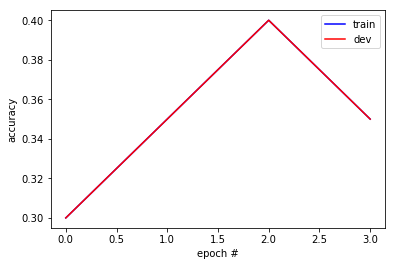

In [27]:
# plot accuracies
train_accuracies = [0,0,0,0]
dev_accuracies = [0,0,0,0]
for idx, accuracy in enumerate(NN_Accuracies):
    train_accuracies[idx] = NN_Accuracies[idx][0]
    dev_accuracies[idx] = NN_Accuracies[idx][1]

plt.plot([0,1,2,3], train_accuracies, 'b-', label='train')
plt.plot([0,1,2,3], dev_accuracies, 'r-', label='dev')
plt.legend(loc='best')
plt.xlabel('epoch #')
plt.ylabel('accuracy')
plt.savefig('accuracy.png', bbox_inches='tight')
plt.show()

In [28]:
# calculate accuracy on test data
testAccuracy, predictions = calculate_NN_accuracy(sentenceSeqs_TEST, sentenceLabels_TEST, fiveCharEncodings, fiveCharLabels_TEST, W1, W2, b1, b2)
print("testAccuracy:", testAccuracy)

('accuracy:', 0.9697986577181208)
('testAccuracy:', 0.9697986577181208)


In [29]:
# produce predictions output file
output = "languageIdentificationPart1.output"
f = open(output, "w")

for sentence, language in predictions.items():
    f.write(sentence.rstrip() + ' ' + language + '\n')

f.close()

In [30]:
# optimize hyperparameters
# return optimal accuracy and best hyperparameters
optimalAccuracy, bestParams = optimize_hyperparameters(sentenceSeqs_t, sentenceLabels_t, fiveCharLabels_t, 
                                 sentenceSeqs_d, sentenceLabels_d, fiveCharLabels_d,
                                     sentenceSeqs_TEST, sentenceLabels_TEST, fiveCharLabels_TEST, 
                                         fiveCharEncodings,  outputSize = 3)

print("Best Performing Hyperparameters: " + "hiddenSize: " + str(bestParams[0]) + " learningRate: " + str(bestParams[1]))
print("Accuracy of best language identifier: " + str(optimalAccuracy))

('accuracy:', 0.35)
('accuracy:', 0.45)
('accuracy:', 0.45)
('accuracy:', 0.3)
('accuracy:', 0.3)
('accuracy:', 0.33221476510067116)
Best Performing Hyperparameters: hiddenSize: 50 learningRate: 10.0
Accuracy of best language identifier: 0.332214765101
